# Contrastive Language-Image Pre-Training (CLIP)

In [1]:
import torch
import clip
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets

In [2]:
# Load the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load('ViT-B/32', device)

## DomainNet Dataset

In [3]:
domain_net_dir = 'data/domain_net'

In [4]:
domains = ['clipart', 'infograph', 'painting', 'quickdraw', 'real', 'sketch']

### Zero-shot Prediction on One Sample

In [5]:
painting_data = datasets.ImageFolder(os.path.join(domain_net_dir, 'painting'), preprocess)
painting_dataloader = DataLoader(painting_data, batch_size=64, shuffle=True, num_workers=6)

In [6]:
# Prepare the inputs
image, class_id = painting_data[4756]
image_input = image.unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f'a painting of a {c}') for c in painting_data.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print(f'\nLabel: {painting_data.classes[class_id]}\n')
print('\nTop predictions:\n')
for value, index in zip(values, indices):
    print(f'{painting_data.classes[index]:>16s}: {100 * value.item():.2f}%')


Label: banana


Top predictions:

          banana: 76.37%
            pear: 3.25%
            shoe: 0.96%
        sandwich: 0.95%
          potato: 0.95%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


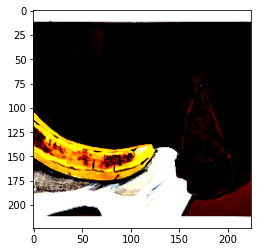

In [7]:
plt.imshow(image.permute(1, 2, 0).numpy())

### Zero-shot Prediction for all Six Domains

In [8]:
def test(domain, data, dataloader):
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    text_inputs = torch.cat([clip.tokenize(f'a {domain} of {c}') for c in data.classes]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            image_features = model.encode_image(images)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=1)
        predictions = similarity.argmax(dim=1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())

    print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f} %')
    
    return 100 * correct / total, all_predictions, all_labels

In [9]:
dsets = {domain: datasets.ImageFolder(os.path.join(domain_net_dir, domain), preprocess) for domain in domains}

In [10]:
dloaders = {domain: DataLoader(data, batch_size=64, shuffle=True, num_workers=6) 
            for domain, data in dsets.items()}

In [13]:
for domain in domains:
    print(f'Accuracy on {domain}:\n')
    accuracy = test(domain, dsets[domain], dloaders[domain])
    print('\n')

Accuracy on clipart:

Accuracy of the network on the 48834 test images: 66.50 %


Accuracy on infograph:

Accuracy of the network on the 53202 test images: 43.37 %


Accuracy on painting:

Accuracy of the network on the 75761 test images: 59.74 %


Accuracy on quickdraw:

Accuracy of the network on the 172510 test images: 14.15 %


Accuracy on real:

Accuracy of the network on the 175327 test images: 80.72 %


Accuracy on sketch:

Accuracy of the network on the 70386 test images: 49.97 %




### Linear Probe for all Six Domains

In [14]:
from tqdm import tqdm

def get_features(data):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(data, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [15]:
from sklearn.linear_model import LogisticRegression

def linear_probe_evaluation(data, train_ratio=0.7):
    # Split into train and test sets
    num_train = int(len(data) * train_ratio)
    num_test = len(data) - num_train
    train, test = torch.utils.data.random_split(data, [num_train, num_test])
    
    # Calculate the image features
    train_features, train_labels = get_features(train)
    test_features, test_labels = get_features(test)

    # Perform logistic regression
    classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    classifier.fit(train_features, train_labels)

    # Evaluate using the logistic regression classifier
    predictions = classifier.predict(test_features)
    accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
    print(f'Accuracy = {accuracy:.2f} %')
    
    return accuracy, predictions, test_labels

In [16]:
for domain in domains:
    print(f'Accuracy on {domain}:\n')
    accuracy = linear_probe_evaluation(dsets[domain])
    print('\n')

Accuracy on clipart:



100%|██████████| 147/147 [01:48<00:00,  1.35it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       176985     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99750D+05    |proj g|=  1.70441D+03


 This problem is unconstrained.



At iterate   50    f=  2.19578D+04    |proj g|=  2.73546D+02

At iterate  100    f=  1.98011D+04    |proj g|=  1.08327D+02

At iterate  150    f=  1.97188D+04    |proj g|=  2.55255D+01

At iterate  200    f=  1.97104D+04    |proj g|=  2.97082D+01

At iterate  250    f=  1.96866D+04    |proj g|=  1.55609D+01

At iterate  300    f=  1.96738D+04    |proj g|=  1.53475D+01

At iterate  350    f=  1.96727D+04    |proj g|=  1.63987D+00

At iterate  400    f=  1.96711D+04    |proj g|=  1.54580D+00

At iterate  450    f=  1.96696D+04    |proj g|=  9.21225D-01

At iterate  500    f=  1.96694D+04    |proj g|=  1.39872D+00

At iterate  550    f=  1.96693D+04    |proj g|=  1.01157D+00

At iterate  600    f=  1.96691D+04    |proj g|=  1.18924D+00

At iterate  650    f=  1.96691D+04    |proj g|=  2.07332D-01

At iterate  700    f=  1.96690D+04    |proj g|=  4.12894D-01

At iterate  750    f=  1.96690D+04    |proj g|=  8.79202D-01

At iterate  800    f=  1.96690D+04    |proj g|=  1.52003D-01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.7min finished



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    914    945      1     0     0   1.184D-01   1.967D+04
  F =   19668.996274894616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Accuracy = 78.14 %


Accuracy on infograph:



100%|██████████| 160/160 [03:51<00:00,  1.45s/it]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       176985     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17619D+05    |proj g|=  2.07195D+03


 This problem is unconstrained.



At iterate   50    f=  5.73185D+04    |proj g|=  4.45453D+02

At iterate  100    f=  5.17624D+04    |proj g|=  9.01190D+01

At iterate  150    f=  5.13414D+04    |proj g|=  2.43655D+01

At iterate  200    f=  5.12966D+04    |proj g|=  1.98073D+01

At iterate  250    f=  5.12806D+04    |proj g|=  1.87296D+01

At iterate  300    f=  5.12566D+04    |proj g|=  2.78765D+01

At iterate  350    f=  5.12426D+04    |proj g|=  6.79421D+00

At iterate  400    f=  5.12402D+04    |proj g|=  1.49863D+01

At iterate  450    f=  5.12388D+04    |proj g|=  4.44613D+00

At iterate  500    f=  5.12369D+04    |proj g|=  4.95576D+00

At iterate  550    f=  5.12362D+04    |proj g|=  1.01945D+00

At iterate  600    f=  5.12360D+04    |proj g|=  1.96677D+00

At iterate  650    f=  5.12358D+04    |proj g|=  5.66424D-01

At iterate  700    f=  5.12356D+04    |proj g|=  3.55272D+00

At iterate  750    f=  5.12355D+04    |proj g|=  1.54234D+00

At iterate  800    f=  5.12355D+04    |proj g|=  6.77960D-01

At iter

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.9min finished



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    857    888      1     0     0   2.670D+00   5.124D+04
  F =   51235.485546000375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Accuracy = 50.41 %


Accuracy on painting:



100%|██████████| 228/228 [03:40<00:00,  1.04it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       176985     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09895D+05    |proj g|=  3.31309D+03


 This problem is unconstrained.



At iterate   50    f=  3.97168D+04    |proj g|=  4.18552D+02

At iterate  100    f=  3.40966D+04    |proj g|=  1.02381D+02

At iterate  150    f=  3.36351D+04    |proj g|=  1.34790D+02

At iterate  200    f=  3.35924D+04    |proj g|=  6.43527D+00

At iterate  250    f=  3.35838D+04    |proj g|=  2.21474D+01

At iterate  300    f=  3.35702D+04    |proj g|=  1.97812D+01

At iterate  350    f=  3.35495D+04    |proj g|=  2.45721D+01

At iterate  400    f=  3.35428D+04    |proj g|=  8.10311D+00

At iterate  450    f=  3.35415D+04    |proj g|=  5.35349D+00

At iterate  500    f=  3.35406D+04    |proj g|=  3.37306D+00

At iterate  550    f=  3.35388D+04    |proj g|=  5.06564D+00

At iterate  600    f=  3.35379D+04    |proj g|=  2.12047D+00

At iterate  650    f=  3.35377D+04    |proj g|=  8.64088D-01

At iterate  700    f=  3.35376D+04    |proj g|=  1.42388D+00

At iterate  750    f=  3.35373D+04    |proj g|=  3.74956D+00

At iterate  800    f=  3.35372D+04    |proj g|=  3.16536D-01

At iter

/home/jovyan/dldiy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.5min finished


Accuracy = 74.54 %


Accuracy on quickdraw:



100%|██████████| 518/518 [05:45<00:00,  1.50it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       176985     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.05643D+05    |proj g|=  4.46684D+02

At iterate   50    f=  2.14190D+05    |proj g|=  1.61325D+03

At iterate  100    f=  1.94768D+05    |proj g|=  5.56829D+02

At iterate  150    f=  1.90344D+05    |proj g|=  2.10487D+02

At iterate  200    f=  1.89461D+05    |proj g|=  1.06980D+02

At iterate  250    f=  1.89290D+05    |proj g|=  6.98081D+01

At iterate  300    f=  1.89250D+05    |proj g|=  5.21707D+01

At iterate  350    f=  1.89239D+05    |proj g|=  3.63389D+01

At iterate  400    f=  1.89230D+05    |proj g|=  9.82122D+00

At iterate  450    f=  1.89205D+05    |proj g|=  2.39475D+01

At iterate  500    f=  1.89154D+05    |proj g|=  1.02450D+02

At iterate  550    f=  1.89114D+05    |proj g|=  3.28752D+01

At iterate  600    f=  1.89093D+05    |proj g|=  2.54254D+01

At iterate  650    f=  1.8

/home/jovyan/dldiy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 32.6min finished


Accuracy = 59.60 %


Accuracy on real:



100%|██████████| 526/526 [07:44<00:00,  1.13it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       176985     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17167D+05    |proj g|=  2.18911D+03

At iterate   50    f=  4.64461D+04    |proj g|=  3.80589D+02

At iterate  100    f=  3.96439D+04    |proj g|=  1.23070D+02

At iterate  150    f=  3.89962D+04    |proj g|=  2.34273D+01

At iterate  200    f=  3.89343D+04    |proj g|=  8.18269D+00

At iterate  250    f=  3.89232D+04    |proj g|=  7.34689D+00

At iterate  300    f=  3.89096D+04    |proj g|=  2.81364D+01

At iterate  350    f=  3.88905D+04    |proj g|=  1.10384D+01

At iterate  400    f=  3.88842D+04    |proj g|=  3.58636D+00

At iterate  450    f=  3.88829D+04    |proj g|=  1.25756D+00

At iterate  500    f=  3.88816D+04    |proj g|=  7.98566D+00

At iterate  550    f=  3.88798D+04    |proj g|=  3.71947D+00

At iterate  600    f=  3.88792D+04    |proj g|=  1.38141D+00

At iterate  650    f=  3.8

/home/jovyan/dldiy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 33.1min finished


Accuracy = 87.09 %


Accuracy on sketch:



100%|██████████| 212/212 [03:28<00:00,  1.02it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       176985     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87911D+05    |proj g|=  2.55812D+03


 This problem is unconstrained.



At iterate   50    f=  4.95486D+04    |proj g|=  5.84143D+02

At iterate  100    f=  4.21542D+04    |proj g|=  9.38781D+01

At iterate  150    f=  4.13936D+04    |proj g|=  8.18806D+01

At iterate  200    f=  4.13065D+04    |proj g|=  1.26420D+01

At iterate  250    f=  4.12866D+04    |proj g|=  2.31907D+01

At iterate  300    f=  4.12624D+04    |proj g|=  3.05023D+01

At iterate  350    f=  4.12333D+04    |proj g|=  2.16659D+01

At iterate  400    f=  4.12225D+04    |proj g|=  1.46090D+01

At iterate  450    f=  4.12195D+04    |proj g|=  6.27367D+00

At iterate  500    f=  4.12162D+04    |proj g|=  1.41945D+01

At iterate  550    f=  4.12114D+04    |proj g|=  5.17891D+00

At iterate  600    f=  4.12091D+04    |proj g|=  2.22034D+01

At iterate  650    f=  4.12084D+04    |proj g|=  3.87600D+00

At iterate  700    f=  4.12079D+04    |proj g|=  1.37492D+01

At iterate  750    f=  4.12071D+04    |proj g|=  1.06691D+01

At iterate  800    f=  4.12067D+04    |proj g|=  3.05290D+00

At iter

/home/jovyan/dldiy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.5min finished


Accuracy = 69.85 %




# Paris/Oxford Buildings Dataset

### Zero-shot Prediction on both Datasets

In [13]:
paris_dir = 'data/paris6k'

In [14]:
paris_dset = datasets.ImageFolder(paris_dir, preprocess)
paris_dloader = DataLoader(paris_dset, batch_size=64, shuffle=True, num_workers=6)

In [15]:
_, paris_predictions, paris_labels = test('photo', paris_dset, paris_dloader)

Accuracy of the network on the 6392 test images: 50.08 %


In [17]:
oxford_dir = 'data/oxford5k'

In [18]:
oxford_dset = datasets.ImageFolder(oxford_dir, preprocess)
oxford_dloader = DataLoader(oxford_dset, batch_size=64, shuffle=True, num_workers=6)

In [19]:
_, oxford_predictions, oxford_labels = test('photo', oxford_dset, oxford_dloader)

Accuracy of the network on the 5063 test images: 18.19 %


### Accuracy by Class on both Datasets

In [21]:
def accuracy_by_class(data, predictions, labels):
    class_correct = [0. for _ in range(len(data.classes))]
    class_total = [0. for _ in range(len(data.classes))]
    
    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += predictions[i] == label
        class_total[label] += 1

    for i, data_class in enumerate(data.classes):
        print('Accuracy of %5s : %2d %%' % (data_class, 100 * class_correct[i] / class_total[i]))

In [20]:
accuracy_by_class(paris_dset, paris_predictions, paris_labels)

Accuracy of defense :  8 %
Accuracy of eiffel : 78 %
Accuracy of general :  2 %
Accuracy of invalides : 69 %
Accuracy of louvre : 92 %
Accuracy of moulinrouge : 87 %
Accuracy of museedorsay : 76 %
Accuracy of notredame : 66 %
Accuracy of pantheon : 26 %
Accuracy of pompidou : 77 %
Accuracy of sacrecoeur : 69 %
Accuracy of triomphe : 79 %


In [22]:
accuracy_by_class(oxford_dset, oxford_predictions, oxford_labels)

Accuracy of all_souls :  0 %
Accuracy of ashmolean : 56 %
Accuracy of balliol : 29 %
Accuracy of bodleian : 75 %
Accuracy of christ_church :  7 %
Accuracy of cornmarket : 52 %
Accuracy of hertford :  2 %
Accuracy of jesus :  4 %
Accuracy of keble : 44 %
Accuracy of magdalen : 10 %
Accuracy of   new : 24 %
Accuracy of oriel : 10 %
Accuracy of oxford : 12 %
Accuracy of pitt_rivers : 67 %
Accuracy of radcliffe_camera :  2 %
Accuracy of trinity :  0 %
Accuracy of worcester :  4 %


### Confusion Matrices for both Datasets

In [24]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(predictions, labels, 
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(labels, predictions, labels=[i for i in range(len(classes))])
    
    plt.figure(figsize = (len(classes) * 0.8, len(classes) * 0.8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix, with normalization")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')

Confusion matrix, without normalization


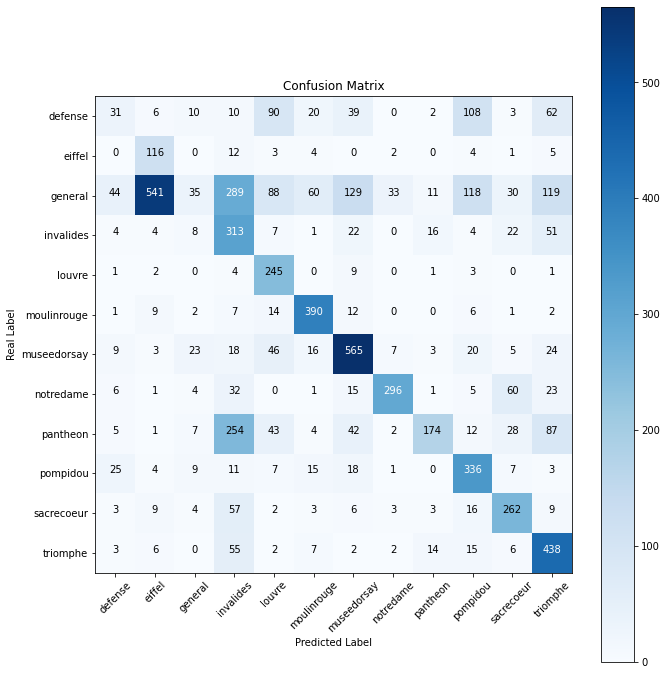

In [23]:
plot_confusion_matrix(paris_predictions, paris_labels, paris_dset.classes)

Confusion matrix, without normalization


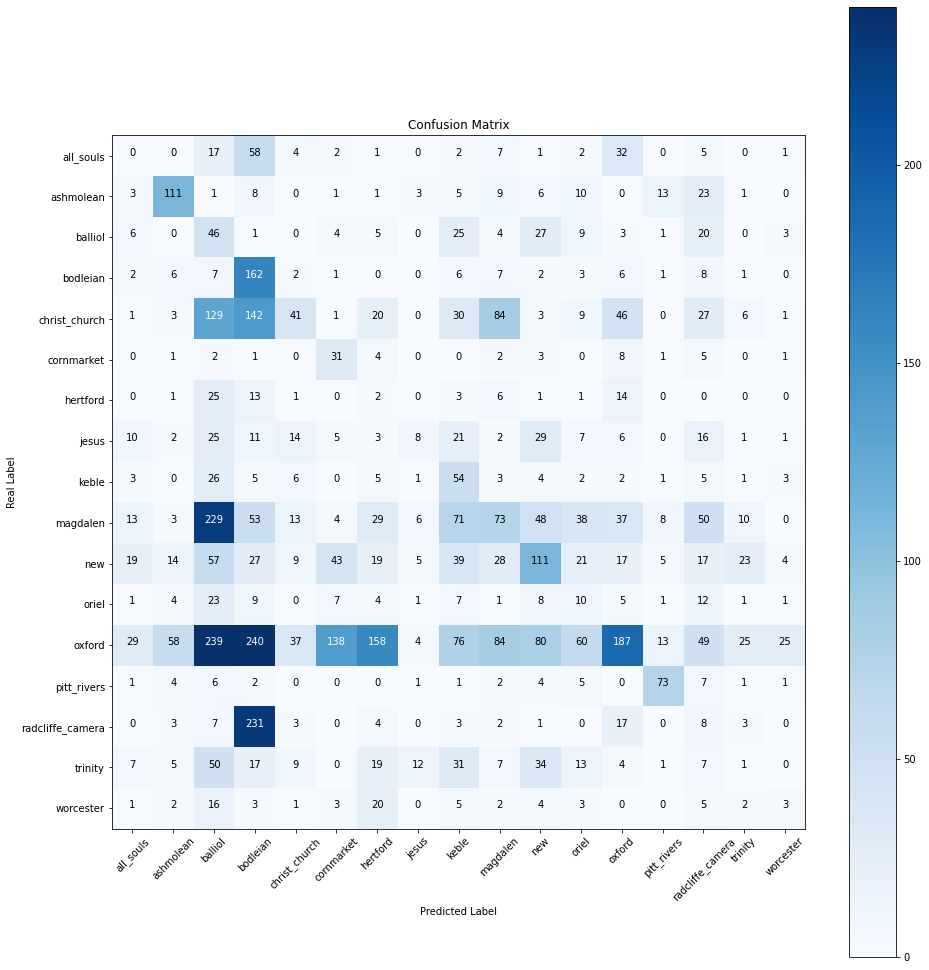

In [25]:
plot_confusion_matrix(oxford_predictions, oxford_labels, oxford_dset.classes)

### Linear Probe on both Datasets

In [25]:
_, paris_predictions, paris_labels = linear_probe_evaluation(paris_dset)

100%|██████████| 20/20 [00:41<00:00,  2.07s/it]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6156     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11175D+04    |proj g|=  4.56567D+03

At iterate   50    f=  1.93858D+03    |proj g|=  4.58636D+01

At iterate  100    f=  1.82627D+03    |proj g|=  1.18539D+01

At iterate  150    f=  1.82121D+03    |proj g|=  4.81731D+00

At iterate  200    f=  1.82024D+03    |proj g|=  5.59184D+00

At iterate  250    f=  1.81860D+03    |proj g|=  7.35764D+00

At iterate  300    f=  1.81820D+03    |proj g|=  5.62440D+00

At iterate  350    f=  1.81812D+03    |proj g|=  3.20157D+00

At iterate  400    f=  1.81794D+03    |proj g|=  2.43794D+00

At iterate  450    f=  1.81781D+03    |proj g|=  7.04791D-01

At iterate  500    f=  1.81780D+03    |proj g|=  6.74759D-01

At iterate  550    f=  1.81779D+03    |proj g|=  3.41172D-01

At iterate  600    f=  1.81779D+03    |proj g|=  3.92937D-01

           * * *

Tit   = 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


In [26]:
_, oxford_predictions, oxford_labels = linear_probe_evaluation(oxford_dset)

100%|██████████| 16/16 [00:31<00:00,  1.95s/it]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8721     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00409D+04    |proj g|=  4.94089D+03

At iterate   50    f=  3.24638D+03    |proj g|=  4.56832D+01

At iterate  100    f=  3.02118D+03    |proj g|=  8.49338D+00

At iterate  150    f=  3.00385D+03    |proj g|=  3.36168D+00

At iterate  200    f=  3.00212D+03    |proj g|=  6.33906D+00

At iterate  250    f=  3.00027D+03    |proj g|=  2.48002D+00

At iterate  300    f=  2.99858D+03    |proj g|=  1.06971D+01

At iterate  350    f=  2.99782D+03    |proj g|=  3.44238D+00

At iterate  400    f=  2.99737D+03    |proj g|=  3.30129D+00

At iterate  450    f=  2.99714D+03    |proj g|=  1.00935D+00

At iterate  500    f=  2.99697D+03    |proj g|=  1.31262D+00

At iterate  550    f=  2.99685D+03    |proj g|=  4.88904D-01

At iterate  600    f=  2.99681D+03    |proj g|=  7.38991D-01

At iterate  650    f=  2.9

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


In [27]:
accuracy_by_class(paris_dset, paris_predictions, paris_labels)

Accuracy of defense : 80 %
Accuracy of eiffel :  4 %
Accuracy of general : 76 %
Accuracy of invalides : 77 %
Accuracy of louvre : 90 %
Accuracy of moulinrouge : 87 %
Accuracy of museedorsay : 86 %
Accuracy of notredame : 85 %
Accuracy of pantheon : 83 %
Accuracy of pompidou : 78 %
Accuracy of sacrecoeur : 75 %
Accuracy of triomphe : 84 %


In [27]:
accuracy_by_class(oxford_dset, oxford_predictions, oxford_labels)

Accuracy of all_souls : 50 %
Accuracy of ashmolean : 82 %
Accuracy of balliol : 38 %
Accuracy of bodleian : 48 %
Accuracy of christ_church : 54 %
Accuracy of cornmarket : 20 %
Accuracy of hertford : 32 %
Accuracy of jesus : 35 %
Accuracy of keble : 45 %
Accuracy of magdalen : 60 %
Accuracy of   new : 48 %
Accuracy of oriel : 25 %
Accuracy of oxford : 66 %
Accuracy of pitt_rivers : 77 %
Accuracy of radcliffe_camera : 76 %
Accuracy of trinity : 47 %
Accuracy of worcester : 33 %


Confusion matrix, without normalization


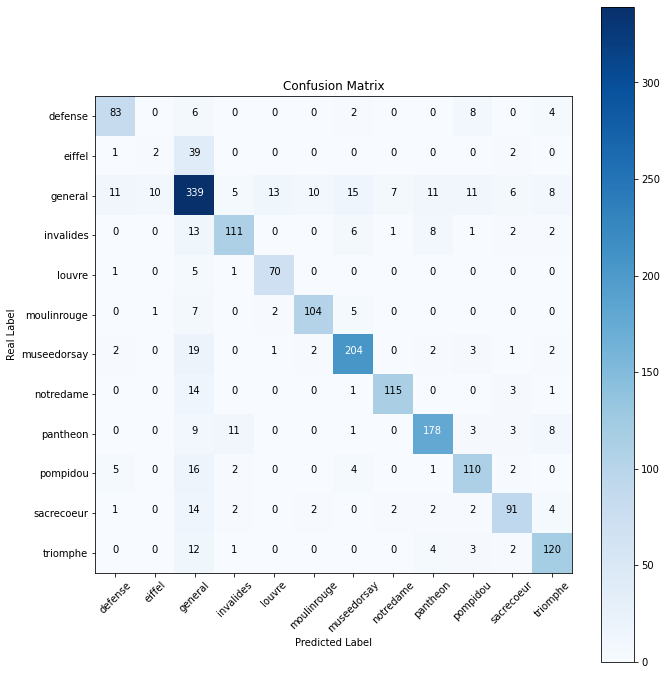

In [29]:
plot_confusion_matrix(paris_predictions, paris_labels, paris_dset.classes)

Confusion matrix, without normalization


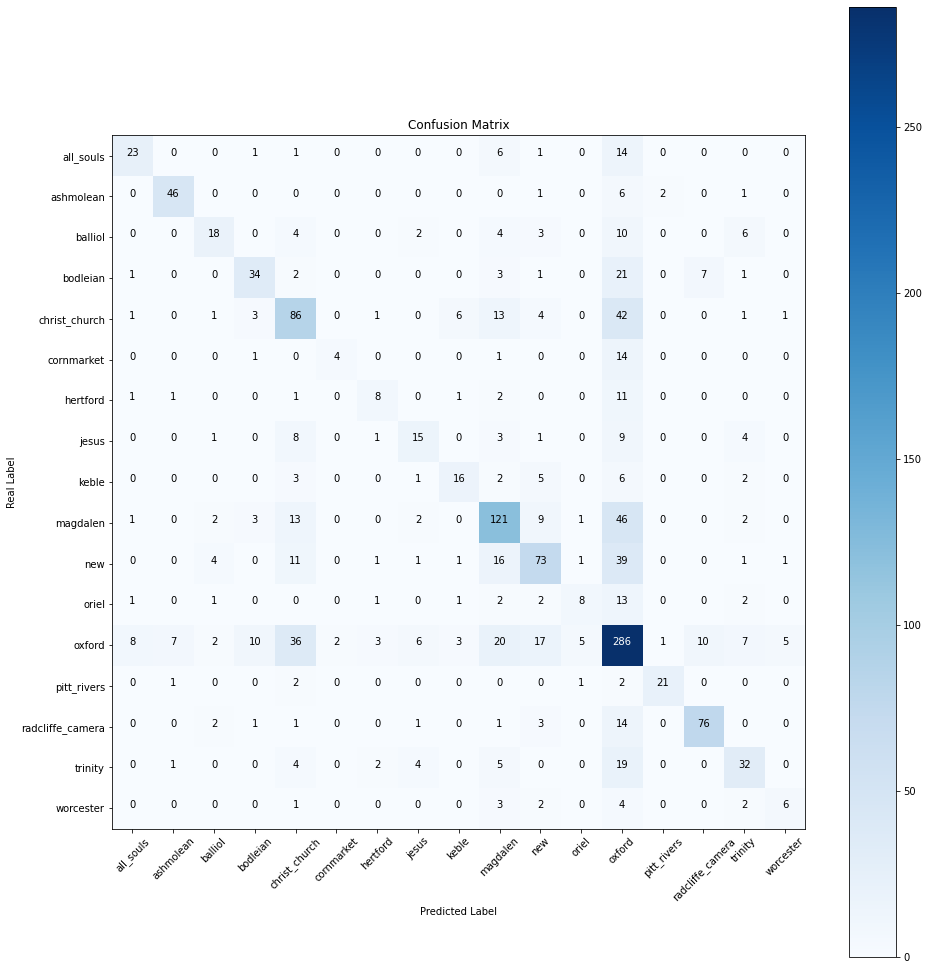

In [28]:
plot_confusion_matrix(oxford_predictions, oxford_labels, oxford_dset.classes)

## Wikiart Dataset

In [28]:
wikiart_dir = 'data/wikiart'

In [29]:
wikiart_dset = datasets.ImageFolder(wikiart_dir, preprocess)
wikiart_dloader = DataLoader(wikiart_dset, batch_size=64, shuffle=True, num_workers=6)

In [30]:
_, wikiart_predictions, wikiart_labels = test('painting', wikiart_dset, wikiart_dloader)

/home/jovyan/dldiy/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/jovyan/dldiy/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Accuracy of the network on the 36432 test images: 38.69 %


In [31]:
accuracy_by_class(wikiart_dset, wikiart_predictions, wikiart_labels)

Accuracy of Abstract_Expressionism : 54 %
Accuracy of Action_painting :  3 %
Accuracy of Analytical_Cubism : 98 %
Accuracy of Baroque : 85 %
Accuracy of Color_Field_Painting : 27 %
Accuracy of Fauvism : 80 %
Accuracy of High_Renaissance : 63 %
Accuracy of Impressionism : 52 %
Accuracy of Naive_Art_Primitivism : 39 %
Accuracy of New_Realism : 21 %
Accuracy of Pop_Art : 30 %
Accuracy of Realism :  8 %
Accuracy of Synthetic_Cubism :  1 %


Confusion matrix, without normalization


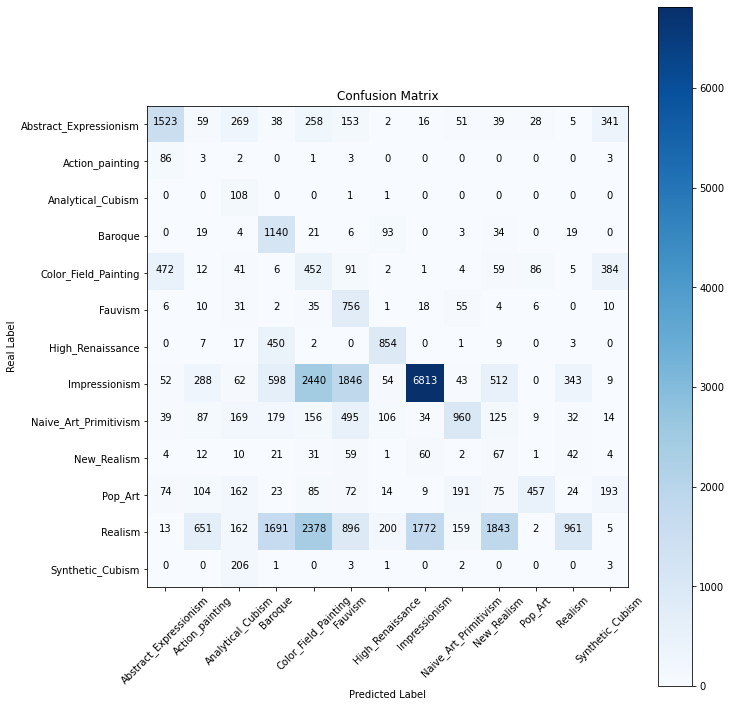

In [58]:
plot_confusion_matrix(wikiart_predictions, wikiart_labels, wikiart_dset.classes)

In [32]:
_, wikiart_predictions, wikiart_labels = linear_probe_evaluation(wikiart_dset)

 28%|██▊       | 71/256 [03:11<06:13,  2.02s/it]/home/jovyan/dldiy/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 51%|█████     | 131/256 [05:32<04:48,  2.31s/it]/home/jovyan/dldiy/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 110/110 [04:09<00:00,  2.26s/it]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6669     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54113D+04    |proj g|=  3.45452D+04

At iterate   50    f=  1.19463D+04    |proj g|=  3.21441D+02

At iterate  100    f=  1.09916D+04    |proj g|=  3.93977D+02

At iterate  150    f=  1.07607D+04    |proj g|=  1.83978D+02

At iterate  200    f=  1.06912D+04    |proj g|=  8.48476D+01

At iterate  250    f=  1.06717D+04    |proj g|=  3.19304D+01

At iterate  300    f=  1.06659D+04    |proj g|=  2.75470D+01

At iterate  350    f=  1.06638D+04    |proj g|=  3.85974D+00

At iterate  400    f=  1.06628D+04    |proj g|=  1.11848D+01

At iterate  450    f=  1.06619D+04    |proj g|=  1.48020D+01

At iterate  500    f=  1.06609D+04    |proj g|=  2.58104D+01

At iterate  550    f=  1.06593D+04    |proj g|=  1.47616D+01

At iterate  650    f=  1.06573D+04    |proj g|=  7.19154D+00

At iterate  700    f=  1.0

/home/jovyan/dldiy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.1s finished


In [33]:
accuracy_by_class(wikiart_dset, wikiart_predictions, wikiart_labels)

Accuracy of Abstract_Expressionism : 82 %
Accuracy of Action_painting : 20 %
Accuracy of Analytical_Cubism : 80 %
Accuracy of Baroque : 76 %
Accuracy of Color_Field_Painting : 79 %
Accuracy of Fauvism : 65 %
Accuracy of High_Renaissance : 83 %
Accuracy of Impressionism : 85 %
Accuracy of Naive_Art_Primitivism : 82 %
Accuracy of New_Realism : 40 %
Accuracy of Pop_Art : 74 %
Accuracy of Realism : 80 %
Accuracy of Synthetic_Cubism : 88 %


Confusion matrix, without normalization


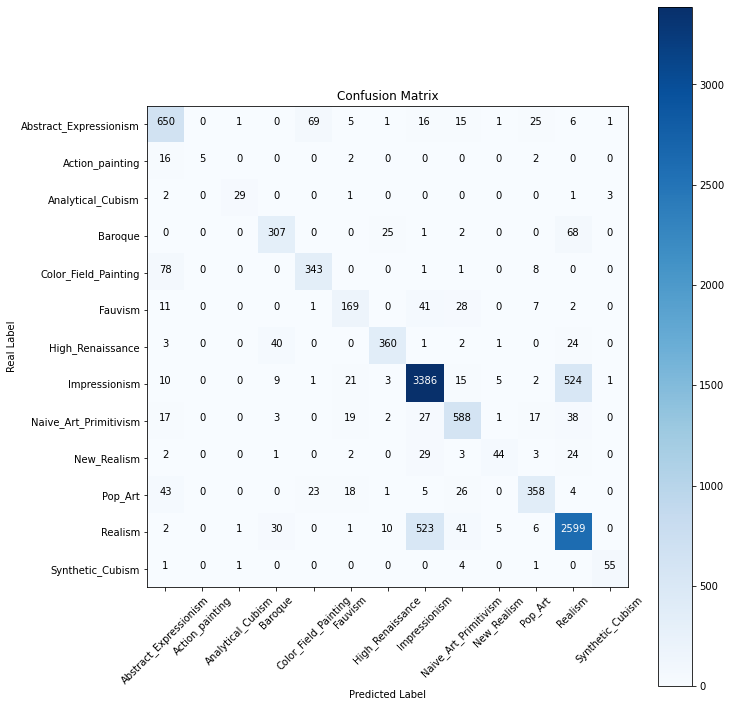

In [55]:
plot_confusion_matrix(wikiart_predictions, wikiart_labels, wikiart_dset.classes)